# Shoreline Derivation


_**Caitlin Haedrich and Pratikshya Regmi**, North Carolina State University_


A shoreline is the interface between the land and the ocean. The location of the shoreline is fundamentally important to various aspects of coastal science and engineering. However, the cross-shore and vertical location of the shoreline continuously changes both temporally and spatially. Thus, differing definitions of the shoreline exist for various applications. Shoreline location is often approximated by a constant elevation contour drawn in a tidal datum. The specific tidal datum and contour elevation may depend on the application. The following figure shows the shoreline migration range in the town of Nags Head, North Carolina (image from [Hardin et al. (2014)](https://link.springer.com/book/10.1007/978-1-4939-1835-5).

![](img/shoreline.png)

In this notebook we will:
* [Derive Shorelines from DEMs](#2.-Deriving-and-Smoothing-Shorelines)
* [Visualization of the extracted shorelines](#3.-Visualization)

***

## 1. Import Python Packages and Start GRASS Session

In [1]:
import subprocess
import sys
from pathlib import Path

sys.path.append(
    subprocess.check_output(["grass", "--config", "python_path"], text=True, shell=False).strip()
)

import grass.script as gs
import grass.jupyter as gj

gj.init("./nags_head/PERMANENT");

Before we get started, we check the computational region.

In [2]:
!g.region -p

projection: 99 (NAD83(HARN) / North Carolina)
zone:       0
datum:      nad83harn
ellipsoid:  grs80
north:      250984
south:      249364
west:       912140
east:       914462
nsres:      2
ewres:      2
rows:       810
cols:       1161
cells:      940410


We can double check the extent by using the `use_region=True` keyword in `gj.Map`. This will only display layers that are within the computational extent.

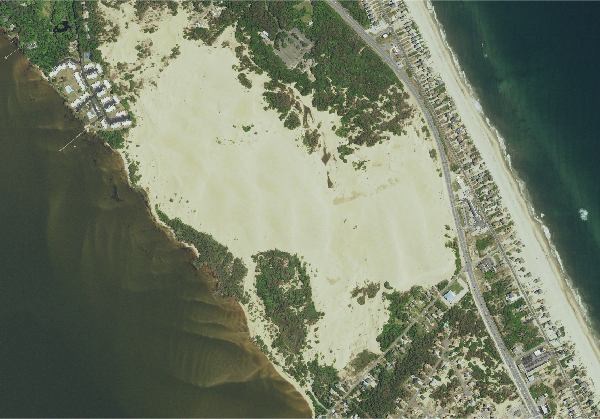

In [3]:
img= gj.Map(use_region=True)
image=img.d_rgb(red="naip_2020.1", green="naip_2020.2", blue="naip_2020.3")
img.show()

In [4]:
!r.composite blue=naip_2020.3 green=naip_2020.2 red=naip_2020.1\
            output=naip_rgb

Creating color table for output raster map...
   0   6  12  18  25  31  37  43  50  56  62  68  75  81  87  93 100
Writing raster map <naip_rgb>...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
r.composite complete. Raster map <naip_rgb> created.


**Try it Yourself!**

_Modify and save the computational region so it is just the eastern shore. This will be useful because we're going to focus on shoreline changes on the seaward side of the barrier island._

<details>
    <summary>👉 <b>click to see some examples</b></summary>

```python
!g.region w=w/2 -p
``` 
    
```python
!g.region region=jockeys_ridge w=w+1200 -p
```
</details>


***

## 2. Deriving and Smoothing Shorelines

In this next part, we use [`r.contour`](https://grass.osgeo.org/grass83/manuals/r.contour.html) to extract the shoreline contour and [`v.generalize`](https://grass.osgeo.org/grass83/manuals/v.generalize.html) to smooth and clean the resulting line.

**Try it Yourself!**

_Modify the parameters to see how the resulting shoreline changes._

In [5]:
shoreline_elev = 0.8 # shoreline proxy elevation in meters
min_points = 400 # minimum number of points for a contour line (threshold to exclude small anomalies)

gs.run_command('r.contour', input="JR_2014", output="JR_2014_contour", levels=shoreline_elev, cut=min_points)
gs.run_command('v.generalize',input="JR_2014_contour", output="JR_2014_shoreline", method='sliding_averaging', threshold=0, look_ahead=51)

### Batch Shoreline Derivation

Let's use a for-loop to automate the process and repeat it for all of our elevation rasters.

In [6]:
elev_rasters = gs.read_command("g.list", type="vector", pattern="JR_????").split()
elev_rasters

['JR_2014']

In [7]:
shoreline_elev = 0.8 # shoreline proxy elevation
min_points = 400 # threshold to exclude small anomalies

for raster in elev_rasters:
    # Set output names
    contour = f'{raster}_contour'
    shoreline = f'{raster}_shoreline'
    # derive shorelines
    gs.run_command('r.contour', input=raster, output=contour, levels=shoreline_elev, cut=min_points)
    gs.run_command('v.generalize',input=contour, output=shoreline, method='sliding_averaging', threshold=0, look_ahead=51)

***

## 3. Visualization

In [8]:
shoreline_series = gs.read_command("g.list", type="vector", pattern="*shoreline").split()
shoreline_series

['JR_2014_shoreline',
 'JR_2016_shoreline',
 'JR_2018_shoreline',
 'JR_2020_shoreline']

Here's a quick little bit of code making unique colors for each shoreline so we can see change over time better.

In [9]:
n = len(shoreline_series)
colors = []

for i in range(n):
    # Generate shades of blue
    blue = int((i / (n)) * 255)
    # Convert RGB to hexadecimal format
    color = "#{:02x}{:02x}{:02x}".format(0, 0, blue)  # Pure blue with varying intensity
    colors.append(color)

print(colors)

['#000000', '#00003f', '#00007f', '#0000bf']


With a list of our shoreline vectors and hex colors, we can make an interactive map.


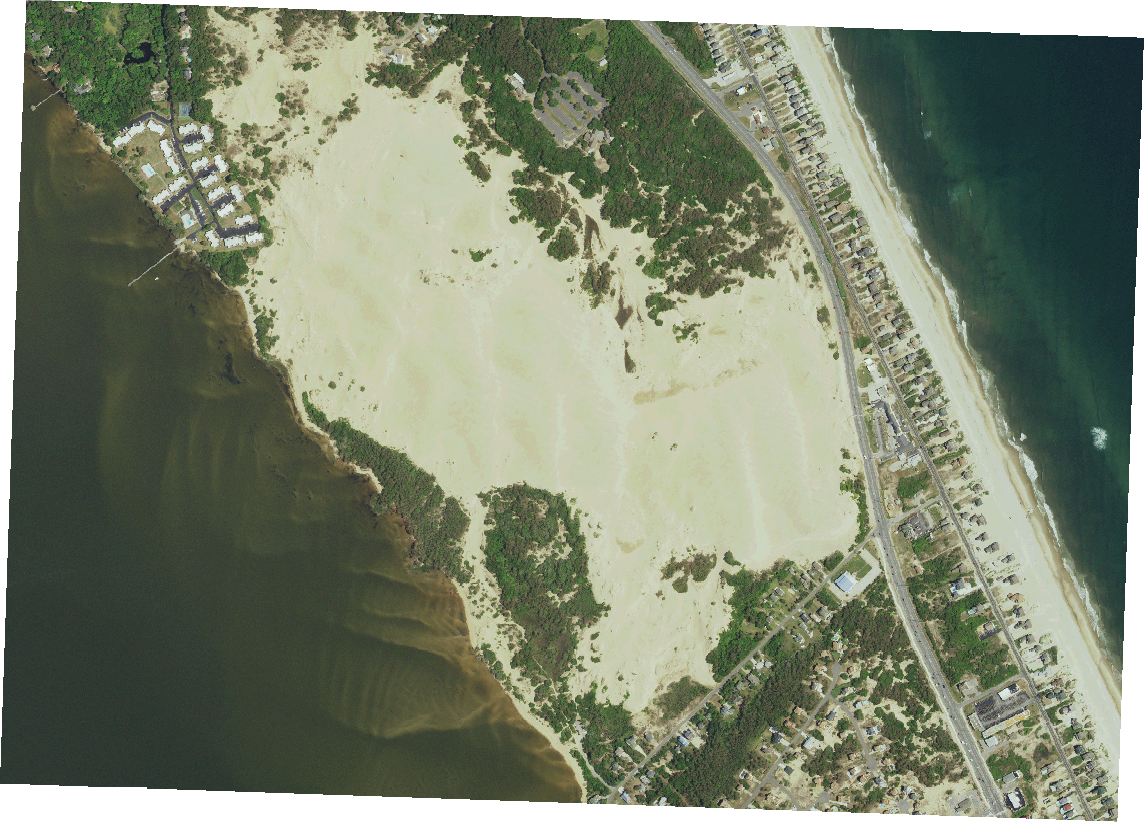

In [10]:
img=gj.InteractiveMap(width=800, tiles="OpenStreetMap")
for i, shoreline in enumerate(shoreline_series):
    img.add_vector(shoreline, color=colors[i])
img.add_raster("naip_rgb")
img.add_layer_control()

img.show()

## Take it further

What to get more advanced? Check out the [LINK TO ADVANCED NOTEBOOK] where we identify the foredune toe and ridge!